# **EECS 442 PS9: Neural Radiance Fields**

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

Sonia Minseo Kim, kminseo

## Brief Overview

In this problem set, you will implement Neural Radiance Fields (NeRF).

A NeRF is an MLP that can generate novel views 3D scenes. It is trained on a set of 2D images with camera poses. The network takes viewing direction and spatial location (5D vector) as input and predicts opacity and RGB color (4D vector), and the novel views are rendered using volume rendering.



## 9.0 Starting

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install imageio-ffmpeg
!pip install torchsummary

In [4]:
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import os, imageio
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms.functional as TF
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

Using the GPU!


## 9.1 Fit Single Image using MLP

In 9.1, we will first study the importance of positional encoding.

We will fit a single image using an MLP. The MLP takes the 2D coordinate of each pixel as input and directly predict its RGB value. Our experiments will show that different positional encoding methods will significantly affect the result fidelity.

Functions to implement:


1.   (2 points) ${\tt input\_mapping(self, x, B)}$ in 9.1.1
2.   (1 points) base Fourier features matrix ${\tt B}$ in 9.1.4
3.   (1 points) full Fourier features matrix ${\tt B}$ in 9.1.5



### 9.1.0 Setup Data

Let's first download a photo from flickr and use it as our target image.

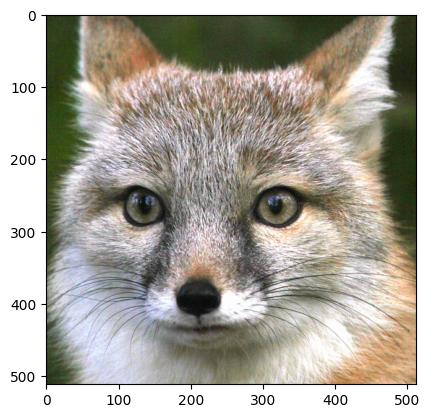

In [ ]:
# Download image, take a square crop from the center
image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
img = imageio.v2.imread(image_url)[..., :3] / 255.
c = [img.shape[0]//2, img.shape[1]//2]
r = 256
img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]
plt.imshow(img)
plt.show()
# Create input pixel coordinates in the unit square
coords = np.linspace(0, 1, img.shape[0], endpoint=False)
input_coords = np.stack(np.meshgrid(coords, coords), -1)
# Define input and target
input_coords = TF.to_tensor(input_coords)
target_img = TF.to_tensor(img)

### 9.1.1 Implement MLP

We will first build an MLP that takes 2D coordinates as input and apply different input mapping methods.

If the Fourier feature mapping matrix is provided, the model will first encode the input $x$ into $\gamma(x)=(\text{sin}(2\pi x),\text{cos}(2\pi x), \cdots, \text{sin}(2^{n}\pi x),\text{cos}(2^{n}\pi x))$.


In [ ]:
class MLP(nn.Module):
  """
  A simple Multilayer Perceptron (MLP) model designed to fit a single image. The model takes 2D coordinates as input
  and predicts RGB pixel values. It optionally uses Fourier feature mapping for input transformation, which can help
  in learning high-frequency components in the image.

  Parameters:
  B (torch.Tensor, optional): A tensor for Fourier feature mapping. If provided, it transforms the input coordinates
                              before passing them through the MLP. Default is None.
  """

  def __init__(self, B=None):
    super(MLP, self).__init__()
    if B is None:
      # Standard input dimension (2 for 2D coordinates).
      self.layer1 = nn.Linear(2, 64)
    else:
      # Input dimension is adjusted based on the Fourier feature tensor B.
      input_dim = B.shape[0] * 2
      self.layer1 = nn.Linear(input_dim, 64)

    self.layer2 = nn.Linear(64, 64)
    self.layer3 = nn.Linear(64, 3)

    # Store the Fourier feature tensor.
    self.B = B

  # Fourier feature mapping function.
  def input_mapping(self, x, B):
    """
    Apply Fourier feature mapping to the input if a tensor B is provided.
    This mapping uses sinusoidal functions to project input coordinates.

    Parameters:
    x (torch.Tensor): The input tensor (2D coordinates).
    B (torch.Tensor): The tensor used for Fourier feature mapping.

    Returns:
    torch.Tensor: The transformed input tensor.
    """
    if B is None:
      return x
    else:
      #############################################################################
      #                                   TODO                                    #
      #############################################################################
      features = (2.*np.pi*x) @ B.T
      # transformed = np.concatenate([np.sin(features), np.cos(features)], axis=-1)
      transformed = torch.cat([torch.sin(features), torch.cos(features)], dim=-1)
      return transformed

      #############################################################################
      #                             END OF YOUR CODE                              #
      #############################################################################


  def forward(self, x):
    """
    Defines the forward pass of the MLP.

    Parameters:
    x (torch.Tensor): The input tensor (2D coordinates).

    Returns:
    torch.Tensor: The output tensor representing RGB pixel values.
    """
    # Apply Fourier feature mapping to the input.
    x = self.input_mapping(x, self.B)

    x = torch.relu(self.layer1(x))
    x = torch.relu(self.layer2(x))

    x = torch.sigmoid(self.layer3(x))

    return x

### 9.1.2 Trainer

Next we build a trainer class that wraps up the training loop of the image fitting task.

In [ ]:
class Trainer:
  """
  Trainer class for training an MLP model on a single image fitting task.
  This class handles the training loop, loss computation, optimization, and visualization of the training process.

  Parameters:
  model (torch.nn.Module): The MLP model.
  input_coords (torch.Tensor): The input coordinates for the MLP model.
  target_img (torch.Tensor): The target image that the MLP model aims to approximate.
  learning_rate (float): The learning rate for the optimizer.
  device (torch.device): The device (CPU or GPU) to run the training on.
  """
  def __init__(self, model, input_coords, target_img, learning_rate, device):
    self.model = model
    self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    self.criterion = nn.MSELoss()
    self.input_coords = torch.permute(input_coords, (1,2,0)).float()
    self.target_img = torch.permute(target_img, (1,2,0)).float()
    self.device = device

  def visualize(self, outputs, targets):
    outputs = outputs.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()

    # Assuming batch size is 1 for simplicity in visualization
    output_image = outputs
    target_image = targets

    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(np.clip(output_image, 0, 1))
    plt.title("Prediction")

    plt.subplot(1, 2, 2)
    plt.imshow(np.clip(target_image, 0, 1))
    plt.title("Target")

    plt.show()

  def train(self, iterations=1000):
    self.model.train()
    for iter in tqdm(range(iterations),leave=False):
      inputs, targets = self.input_coords.to(self.device), self.target_img.to(self.device)
      self.optimizer.zero_grad()
      outputs = self.model(inputs)
      loss = self.criterion(outputs, targets)
      loss.backward()
      self.optimizer.step()

      if iter % (iterations//2) == 0 or iter == iterations-1:
        self.visualize(outputs, targets)
        print(f'Iteration [{iter+1}/{iterations}], Loss: {loss.item():.4f}')

### 9.1.3 Train with raw coordinates

Let's first try fitting the image using the raw 2D coordinates.

Due to lack of high frequency information, the network prediction will be very blurry.

  0%|          | 0/1000 [00:00<?, ?it/s]

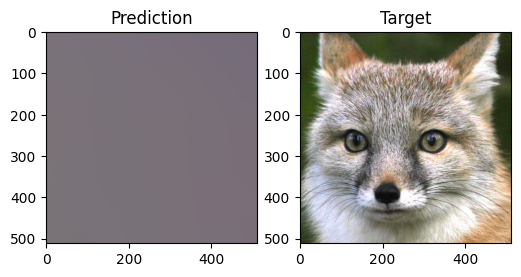

Iteration [1/1000], Loss: 0.0715


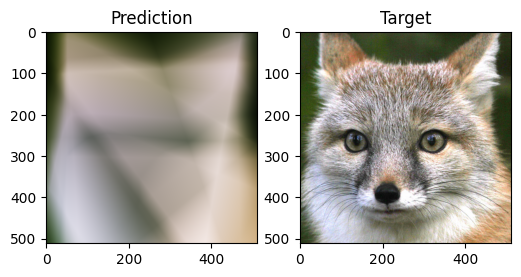

Iteration [501/1000], Loss: 0.0240


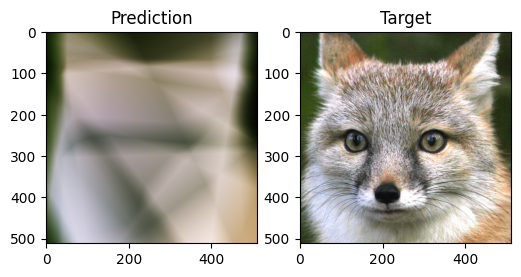

Iteration [1000/1000], Loss: 0.0211


In [ ]:
mlp = MLP(B=None).to(device)
trainer = Trainer(
    model = mlp,
    input_coords = input_coords,
    target_img = target_img,
    learning_rate = 1e-2,
    device = device
)
trainer.train(1000)

### 9.1.4 Train with base Fourier features

Next, we apply a base Fourier positional encoding.

Given an input $x$, we will encode it into $\gamma(x)=(\text{sin}(2\pi x),\text{cos}(2\pi x))$.

The result will be significantly better than raw 2D coordinates, but the details will still be missing.

  0%|          | 0/1000 [00:00<?, ?it/s]

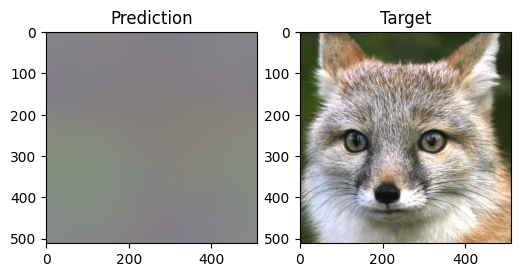

Iteration [1/1000], Loss: 0.0638


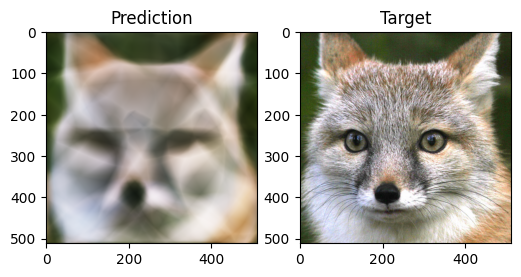

Iteration [501/1000], Loss: 0.0109


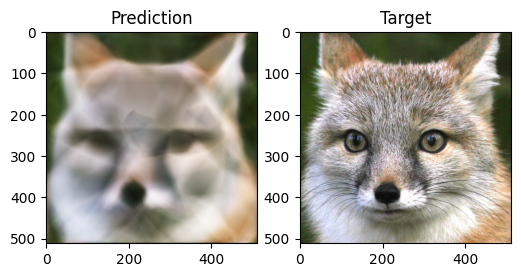

Iteration [1000/1000], Loss: 0.0100


In [ ]:
feature_dim = 2
B = torch.zeros((feature_dim,2)).to(device)
#############################################################################
#                                   TODO                                    #
#############################################################################
B = torch.eye(2).to(device)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
mlp = MLP(B=B).to(device)
trainer = Trainer(
    model = mlp,
    input_coords = input_coords,
    target_img = target_img,
    learning_rate = 1e-2,
    device = device
)
trainer.train(1000)

### 9.1.5 Train with full Fourier features

Finally, we apply a full version of Fourier positional encoding.

Given an input $x$, we will encode it into $\gamma(x)=(\text{sin}(2\pi x),\text{cos}(2\pi x), \cdots, \text{sin}(2^{n}\pi x),\text{cos}(2^{n}\pi x))$.

This will force the network to pay attention to high frequencies and achieve realistic prediction that is almost the same as the target image.

  0%|          | 0/1000 [00:00<?, ?it/s]

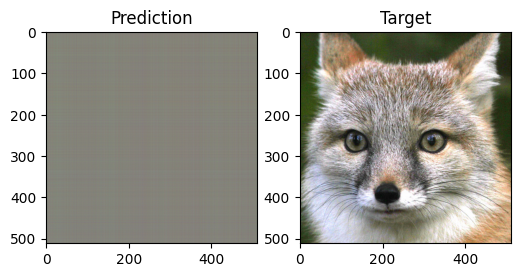

Iteration [1/1000], Loss: 0.0645


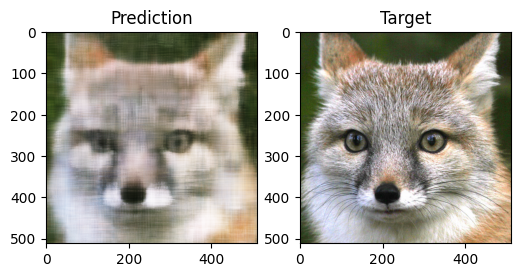

Iteration [501/1000], Loss: 0.0095


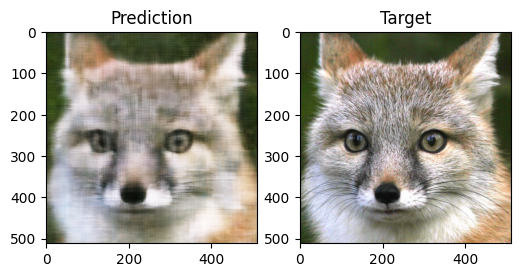

Iteration [1000/1000], Loss: 0.0073


In [ ]:
feature_dim = 64
B = torch.zeros((feature_dim,2)).to(device)
#############################################################################
#                                   TODO                                    #
#############################################################################
for k in range(feature_dim):
  if k % 2 ==0:
    B[k,0] = 2**k
  else:
    B[k,1] = 2**(k-1)

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
mlp = MLP(B=B).to(device)
trainer = Trainer(
    model = mlp,
    input_coords = input_coords,
    target_img = target_img,
    learning_rate = 1e-2,
    device = device
)
trainer.train(1000)

## 9.2 Implementation of NeRF

In 9.2, we will implement the NeRF from scratch and build the training pipeline.

We will first generate rays based on camera poses, query the network with positions and directions, and finally use volume rendering to obtain the RGB output.

Fuctions to implement:

1.   Function ${\tt positional\_encoder(x, L\_embed=6)}$ in 9.2.2
2.   Calculation of the 3D points sampled along the rays in 9.2.5
2.   Calculation of ${\tt rgb\_map}$, ${\tt depth\_map}$ in 9.2.5

### 9.2.0 Setup data

To minimize training time, we will use a tiny dataset the only contains 106 images and their camera poses.

In [ ]:
%%capture
!wget -O tiny_nerf_data.npz 'https://drive.google.com/uc?export=download&id=1gt6PXUo9DQgZUEhw-CZJHqr7l0uGO-db'

Images: (106, 100, 100, 3)
Camera Poses: (106, 4, 4)
Focal Length: 138.8889


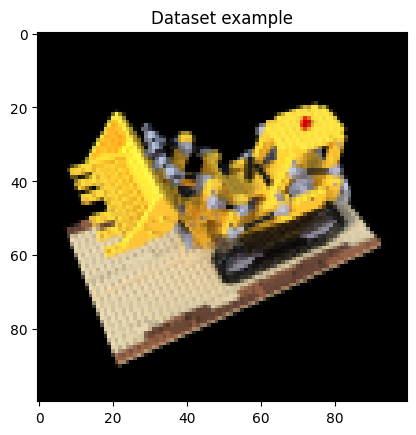

In [ ]:
rawData = np.load("tiny_nerf_data.npz",allow_pickle=True)
images = rawData["images"]
poses = rawData["poses"]
focal = rawData["focal"]
H, W = images.shape[1:3]
H = int(H)
W = int(W)
print("Images: {}".format(images.shape))
print("Camera Poses: {}".format(poses.shape))
print("Focal Length: {:.4f}".format(focal))

testimg, testpose = images[99], poses[99]
plt.imshow(testimg)
plt.title('Dataset example')
plt.show()
images = torch.Tensor(images).to(device)
poses = torch.Tensor(poses).to(device)
testimg = torch.Tensor(testimg).to(device)
testpose = torch.Tensor(testpose).to(device)

### 9.2.1 Generate Rays

Ray generation is a core component of NeRF. We will first implement a function that generates the camera rays for each pixel.

Each ray includes two components: 1) origin and 2) direction.

In [ ]:
def get_rays(H, W, focal, pose):
  """
  This function generates camera rays for each pixel in an image. It calculates the origin and direction of rays
  based on the camera's intrinsic parameters (focal length) and extrinsic parameters (pose).
  The rays are generated in world coordinates, which is crucial for the NeRF rendering process.

  Parameters:
  H (int): Height of the image in pixels.
  W (int): Width of the image in pixels.
  focal (float): Focal length of the camera.
  pose (torch.Tensor): Camera pose matrix of size 4x4.

  Returns:
  tuple: A tuple containing two elements:
      rays_o (torch.Tensor): Origins of the rays in world coordinates.
      rays_d (torch.Tensor): Directions of the rays in world coordinates.
  """
  # Create a meshgrid of image coordinates (i, j) for each pixel in the image.
  i, j = torch.meshgrid(
      torch.arange(W, dtype=torch.float32),
      torch.arange(H, dtype=torch.float32)
  )
  i = i.t()
  j = j.t()

  # Calculate the direction vectors for each ray originating from the camera center.
  # We assume the camera looks towards -z.
  # The coordinates are normalized with respect to the focal length.
  dirs = torch.stack(
      [(i - W * 0.5) / focal,
        -(j - H * 0.5) / focal,
        -torch.ones_like(i)], -1
      ).to(device)

  # Transform the direction vectors (dirs) from camera coordinates to world coordinates.
  # This is done using the rotation part (first 3 columns) of the pose matrix.
  rays_d = torch.sum(dirs[..., np.newaxis, :] * pose[:3, :3], -1)

  # The ray origins (rays_o) are set to the camera position, given by the translation part (last column) of the pose matrix.
  # The position is expanded to match the shape of rays_d for broadcasting.
  rays_o = pose[:3, -1].expand(rays_d.shape)

  # Return the origins and directions of the rays.
  return rays_o, rays_d

### 9.2.2 Positional Encoding

Similar to 9.1, in the NeRF we also leverage Fourier positional encoding to model the high frequencies.

Given an input $x$, we will encode it into $\gamma(x)=(x,\text{sin}(2^{0} x),\text{cos}(2^{0} x), \cdots, \text{sin}(2^{L\_embed-1} x),\text{cos}(2^{L\_embed-1} x))$.

In [ ]:
def positional_encoder(x, L_embed=6):
  """
  This function applies positional encoding to the input tensor. Positional encoding is used in NeRF
  to allow the model to learn high-frequency details more effectively. It applies sinusoidal functions
  at different frequencies to the input.

  Parameters:
  x (torch.Tensor): The input tensor to be positionally encoded.
  L_embed (int): The number of frequency levels to use in the encoding. Defaults to 6.

  Returns:
  torch.Tensor: The positionally encoded tensor.
  """

  # Initialize a list with the input tensor.
  rets = [x]

  # Loop over the number of frequency levels.
  for i in range(L_embed):
    #############################################################################
    #                                   TODO                                    #
    #############################################################################
    freq = 2 ** i
    # Calculate the frequency for each position.
    # freq = 2**(i / L_embed)

    # Apply positional encoding using sine and cosine functions.
    sin_encoding = torch.sin(freq * x)
    rets.append(sin_encoding)
    cos_encoding = torch.cos(freq * x)
    rets.append(cos_encoding)


    # Concatenate the sine and cosine encodings along the last dimension.
    # rets.extend([sin_encoding, cos_encoding])
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################


  # Concatenate the original and encoded features along the last dimension.
  return torch.cat(rets, -1)

### 9.2.3 Cumulative Product

The RGB value of each pixel is computed by a weighted sum of the points along the ray. Higher weight indicates higher opacity, which means the further points will be occluded. The cumulative product fuction ensures this rendering procedure.

In [ ]:
def cumprod_exclusive(tensor: torch.Tensor):
  """
  Compute the exclusive cumulative product of a tensor along its last dimension.
  'Exclusive' means that the cumulative product at each element does not include the element itself.
  This function is used in volume rendering to compute the product of probabilities
  along a ray, excluding the current sample point.

  Parameters:
  tensor (torch.Tensor): The input tensor for which to calculate the exclusive cumulative product.

  Returns:
  torch.Tensor: The tensor after applying the exclusive cumulative product.
  """

  # Compute the cumulative product along the last dimension of the tensor.
  cumprod = torch.cumprod(tensor, -1)

  # Roll the elements along the last dimension by one position.
  # This shifts the cumulative products to make them exclusive.
  cumprod = torch.roll(cumprod, 1, -1)

  # Set the first element of the last dimension to 1, as the exclusive product of the first element is always 1.
  cumprod[..., 0] = 1.

  return cumprod

### 9.2.4 NeRF Model

The main model of NeRF will be implemented here. To reduce training time, we will only use a very small MLP model as our network. The MLP takes the output of positional encoder as input and predicts the opacity and RGB value.

In [ ]:
class VeryTinyNerfModel(torch.nn.Module):
  """
  A very small implementation of a Neural Radiance Field (NeRF) model. This model is a simplified
  version of the standard NeRF architecture, it consists of a simple feedforward neural network with three linear layers.

  Parameters:
  filter_size (int): The number of neurons in the hidden layers. Default is 128.
  num_encoding_functions (int): The number of sinusoidal encoding functions. Default is 6.
  """

  def __init__(self, filter_size=128, num_encoding_functions=6):
    super(VeryTinyNerfModel, self).__init__()
    self.layer1 = torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
    self.layer2 = torch.nn.Linear(filter_size, filter_size)
    self.layer3 = torch.nn.Linear(filter_size, 4)
    self.relu = torch.nn.functional.relu

  def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    x = self.layer3(x)
    return x

### 9.2.5 Volume Rendering

After the implementation of ray generation and MLP model, we can now implement the volume rendering, which is the major procedure of NeRF.

In [ ]:
def render(model, rays_o, rays_d, near, far, n_samples, rand=False):
  """
  Render a scene using a Neural Radiance Field (NeRF) model. This function samples points along rays,
  evaluates the NeRF model at these points, and applies volume rendering techniques to produce an image.

  Parameters:
  model (torch.nn.Module): The NeRF model to be used for rendering.
  rays_o (torch.Tensor): Origins of the rays.
  rays_d (torch.Tensor): Directions of the rays.
  near (float): Near bound for depth sampling along the rays.
  far (float): Far bound for depth sampling along the rays.
  n_samples (int): Number of samples to take along each ray.
  rand (bool): If True, randomize sample depths. Default is False.

  Returns:
  tuple: A tuple containing the RGB map and depth map of the rendered scene.
  """

  # Sample points along each ray, from 'near' to 'far'.
  z = torch.linspace(near, far, n_samples).to(device)
  if rand:
    mids = 0.5 * (z[..., 1:] + z[..., :-1])
    upper = torch.cat([mids, z[..., -1:]], -1)
    lower = torch.cat([z[..., :1], mids], -1)
    t_rand = torch.rand(z.shape).to(device)
    z = lower + (upper - lower) * t_rand

  #############################################################################
  #                                   TODO                                    #
  #############################################################################
  # Compute 3D coordinates of the sampled points along the rays.
  points = rays_o[..., None, :] + rays_d[..., None, :] * z[..., :, None]
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################

  # Flatten the points and apply positional encoding.
  flat_points = torch.reshape(points, [-1, points.shape[-1]])
  flat_points = positional_encoder(flat_points)

  # Evaluate the model on the encoded points in chunks to manage memory usage.
  chunk = 1024 * 32
  raw = torch.cat([model(flat_points[i:i + chunk]) for i in range(0, flat_points.shape[0], chunk)], 0)
  raw = torch.reshape(raw, list(points.shape[:-1]) + [4])

  # Compute densities (sigmas) and RGB values from the model's output.
  sigma = F.relu(raw[..., 3])
  rgb = torch.sigmoid(raw[..., :3])

  # Perform volume rendering to obtain the weights of each point.
  one_e_10 = torch.tensor([1e10], dtype=rays_o.dtype).to(device)
  dists = torch.cat((z[..., 1:] - z[..., :-1], one_e_10.expand(z[..., :1].shape)), dim=-1)
  alpha = 1. - torch.exp(-sigma * dists)
  weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

  #############################################################################
  #                                   TODO                                    #
  #############################################################################
  # Compute the weighted sum of RGB values along each ray to get the final pixel color.
  rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)

  # Compute the depth map as the weighted sum of sampled depths.
  depth_map = torch.sum(weights * z, dim=-1)
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################

  return rgb_map, depth_map

### 9.2.6 Training Loop

In the training loop, the model is trained to fit one image randomly picked from the dataset at each iteration.

In [ ]:
mse2psnr = lambda x : -10. * torch.log(x) / torch.log(torch.Tensor([10.])).to(device)

def train(model, optimizer, n_iters=3000):
  """
  Train the Neural Radiance Field (NeRF) model. This function performs training over a specified number of iterations,
  updating the model parameters to minimize the difference between rendered and actual images.

  Parameters:
  model (torch.nn.Module): The NeRF model to be trained.
  optimizer (torch.optim.Optimizer): The optimizer used for training the model.
  n_iters (int): The number of iterations to train the model. Default is 3000.
  """

  psnrs = []
  iternums = []

  plot_step = 500
  n_samples = 64   # Number of samples along each ray.

  for i in tqdm(range(n_iters)):
    # Randomly select an image from the dataset and use it as the target for training.
    images_idx = np.random.randint(images.shape[0])
    target = images[images_idx]
    pose = poses[images_idx]

    # Compute the rays for the selected image.
    rays_o, rays_d = get_rays(H, W, focal, pose)
    # Render the scene using the current model state.
    rgb, depth = render(model, rays_o, rays_d, near=2., far=6., n_samples=n_samples, rand=True)

    optimizer.zero_grad()
    image_loss = torch.nn.functional.mse_loss(rgb, target)
    image_loss.backward()
    optimizer.step()

    if i % plot_step == 0:
      torch.save(model.state_dict(), 'ckpt.pth')
      # Render a test image to evaluate the current model performance.
      with torch.no_grad():
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth = render(model, rays_o, rays_d, near=2., far=6., n_samples=n_samples)
        loss = torch.nn.functional.mse_loss(rgb, testimg)
        # Calculate PSNR for the rendered image.
        psnr = mse2psnr(loss)

        psnrs.append(psnr.detach().cpu().numpy())
        iternums.append(i)

        # Plotting the rendered image and PSNR over iterations.
        plt.figure(figsize=(9, 3))

        plt.subplot(131)
        picture = rgb.cpu()  # Copy the rendered image from GPU to CPU.
        plt.imshow(picture)
        plt.title(f'RGB Iter {i}')

        plt.subplot(132)
        picture = depth.cpu() * (rgb.cpu().mean(-1)>1e-2)
        plt.imshow(picture, cmap='gray')
        plt.title(f'Depth Iter {i}')

        plt.subplot(133)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()


  0%|          | 0/3000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


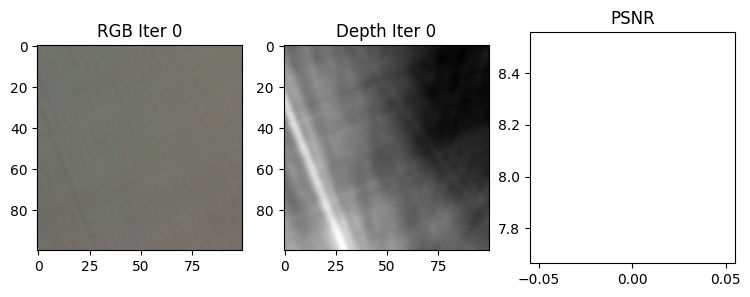

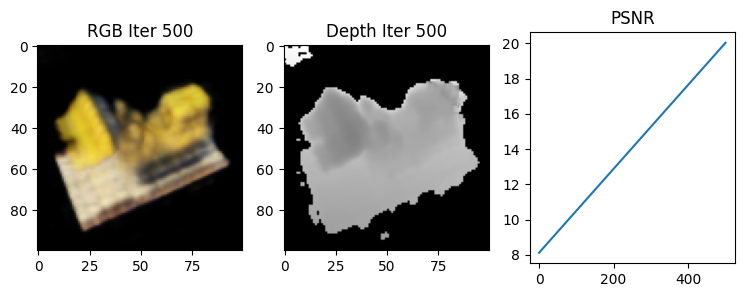

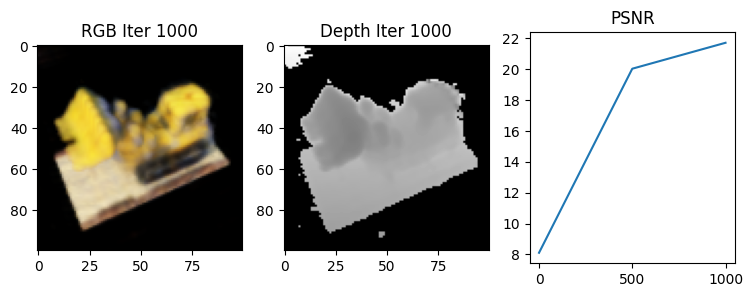

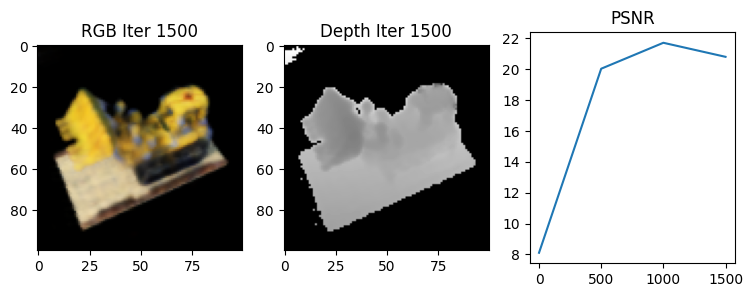

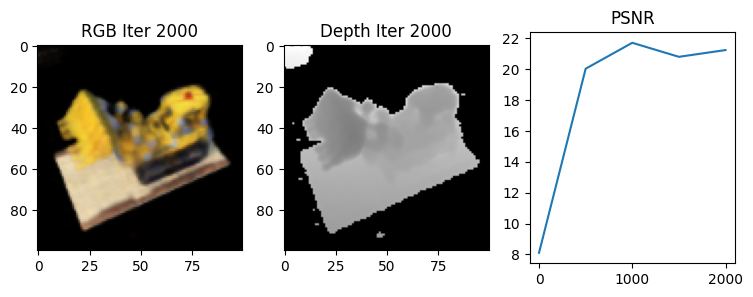

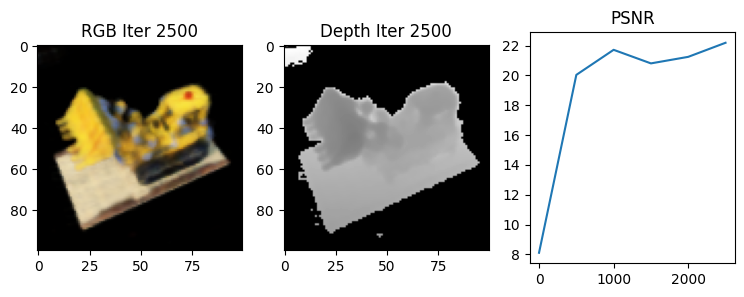

In [ ]:
nerf = VeryTinyNerfModel()
nerf = nn.DataParallel(nerf).to(device)
optimizer = torch.optim.Adam(nerf.parameters(), lr=5e-3, eps = 1e-7)
train(nerf, optimizer)

### 9.2.7 Rendering from different view points.

Given the trained model, we can query it with different camera poses.
In this example, we simply pick three camera poses from the dataset and render the prediction images from them.

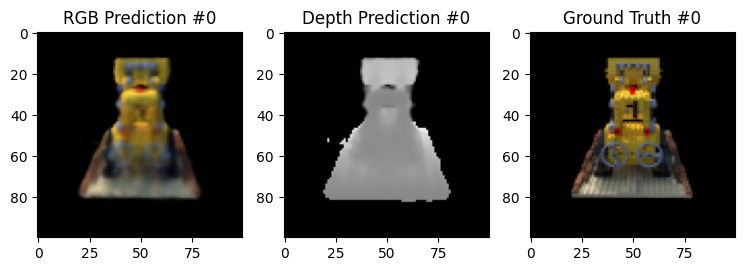

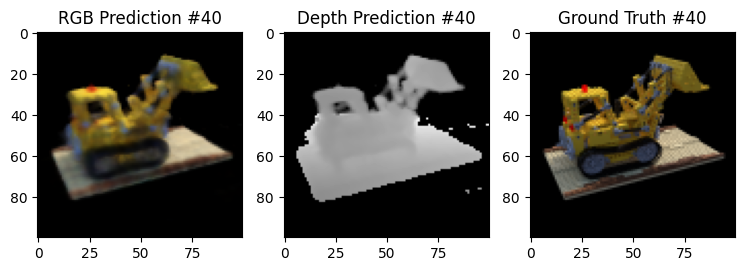

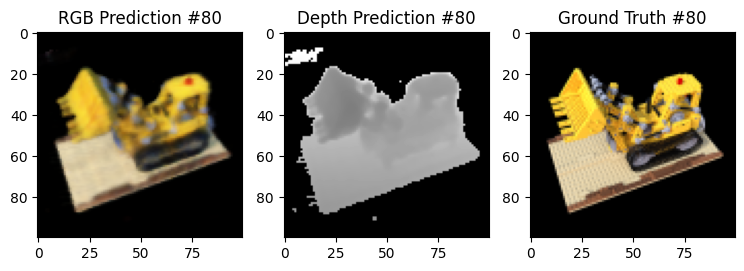

In [ ]:
nerf = VeryTinyNerfModel()
nerf = nn.DataParallel(nerf).to(device)
ckpt = torch.load('ckpt.pth')
nerf.load_state_dict(ckpt)
test_img_idx_list = [0, 40, 80]
H, W = 100, 100
with torch.no_grad():
  for test_img_idx in test_img_idx_list:
    rays_o, rays_d = get_rays(H, W, focal, poses[test_img_idx])
    rgb, depth = render(nerf, rays_o, rays_d, near=2., far=6., n_samples=64)
    plt.figure(figsize=(9,3))

    plt.subplot(131)
    picture = rgb.cpu()
    plt.title("RGB Prediction #{}".format(test_img_idx))
    plt.imshow(picture)

    plt.subplot(132)
    picture = depth.cpu() * (rgb.cpu().mean(-1)>1e-2)
    plt.imshow(picture, cmap='gray')
    plt.title("Depth Prediction #{}".format(test_img_idx))

    plt.subplot(133)
    plt.title("Ground Truth #{}".format(test_img_idx))
    plt.imshow(rawData["images"][test_img_idx])
    plt.show()

In [5]:
# generate pdf
# %%capture
get_ipython().system("pip install pypandoc")
get_ipython().system("apt-get install texlive texlive-xetex texlive-latex-extra pandoc")
drive_mount_point = "/content/drive/"
gdrive_home = os.path.join(drive_mount_point, "My Drive/")
notebookpath="/content/drive/MyDrive/Colab Notebooks/"
# change the name to your ipynb file name shown on the top left of Colab window
# Important: make sure that your file name does not contain spaces!
file_name="kminseo_51459876.ipynb"
get_ipython().system(
  f"jupyter nbconvert --output-dir='{gdrive_home}' '{notebookpath}''{file_name}' --to pdf"
)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
texlive is already the newest version (2021.20220204-1).
texlive-latex-extra is already the newest version (2021.20220204-1).
texlive-xetex is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/Colab Notebooks/kminseo_51459876.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the applicatio